In [10]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")

U2 (generic function with 1 method)

In [11]:
using LinearAlgebra, Optim, Measures, CSV, DataFrames,Plots

In [35]:
ω_c = 5000
ω_q = 3000
χ = 3e-1
N = 6
amp_c = 1
amp_q = 1
T = 0.5

0.5

### Target gate

In [36]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)
#X_gate = kron(x_gate(N, Array[[1,2]]), I_qubit)
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[1,3]], θ), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/4), I_qubit)
Udue = kron(U2(N, Array[[3,4]], [θ/2 θ/3 θ/4] ), I_qubit)

sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])
# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

ψ_initial = zeros(N)
ψ_initial[1] = 1
ψ_initial = kron(ψ_initial/norm(ψ_initial), [0,1])

interaction_transformation(t) = cis(- (ω_c * a' * a + ω_q / 2 * sz) * t)
int_transformation = interaction_transformation(T)

12×12 Matrix{ComplexF64}:
 -0.666983-0.745073im        0.0+0.0im       …       0.0+0.0im
       0.0+0.0im       -0.666983+0.745073im          0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im       …       0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im       …       0.0+0.0im
       0.0+0.0im             0.0+0.0im          0.903266-0.429081im

In [37]:
H_drift = χ * adag * a * sz / 2 #+ ω_c * adag * a + ω_q * sz / 2

12×12 Matrix{Float64}:
 0.0  0.0  0.0    0.0   0.0   0.0  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.15   0.0   0.0   0.0  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0   -0.15  0.0   0.0  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.3   0.0  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0  -0.3  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.45   0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.0   -0.45  0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.0    0.0   0.6   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.0    0.0   0.0  -0.6  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.0    0.0   0.0   0.0  0.75   0.0
 0.0  0.0  0.0    0.0   0.0   0.0  0.0    0.0   0.0   0.0  0.0   -0.75

In [38]:
function cost_from_0_dispersive(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, initial_state, final_state, amp_q=1e-1, amp_c=1e-1)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = final_state' * propagator * initial_state
   
    return 1 - norm(c)^2
end

function cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = tr(unitary' * int_transformation * propagator)/dim
   
    return 1 - norm(c)^2
end

function cost_from_0_dispersive_gate_non_interaction(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = tr(unitary' * propagator)/dim
   
    return 1 - norm(c)^2
end

function propagator(H_drift, sp, sm, a, adag, T, δt, coefficients)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)

    amplitude_c = [ChebyshevT(coefficients[1:Int(length(coefficients)/2)])((2t - T)/T) for t in 0:δt:T]
    amplitude_q = [ChebyshevT(coefficients[Int(length(coefficients)/2) + 1:end])((2t - T)/T) for t in 0:δt:T]


    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for n in 1:1:Int(T/δt)+1
        H = H_drift + (amplitude_q(n) * sp + amplitude_q(n)' * sm) + (amplitude_c(n) * a + amplitude_c(n)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    return propagator * exp(-1im*angle(propagator[8, 8]))
    
end

function gradient(coefficients, unitary, N, h, cost_before_increment,cost)

    L = length(coefficients)
    gradient = zeros(L)

    for i in 1:L
        coeffs_copy = copy(coefficients)
        coeffs_copy[i] = coefficients[i] + h
        gradient[i] = (cost(coeffs_copy) - cost_before_increment) / h
    end

    return gradient

end

gradient (generic function with 2 methods)

In [39]:
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)
snap_params = rand(N) * 2 * pi .- pi
SNAP_GATE = snap(snap_params)

12×12 Matrix{ComplexF64}:
 -0.811137+0.584856im       -0.0+0.0im       …        0.0+0.0im
      -0.0+0.0im       -0.811137+0.584856im           0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im       …        0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im                0.0+0.0im
       0.0+0.0im             0.0+0.0im       …       -0.0-0.0im
       0.0+0.0im             0.0+0.0im          -0.739479-0.67318im

In [40]:
f(x) = cost_from_0_dispersive(H_drift, sp, sm, a, adag, T, T / (10 * 3) , x, X_gate, ω_c, ω_q, ψ_initial, ψ_final_x)
g(x) = cost_from_0_dispersive_gate_non_interaction(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 1, 1)
r(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, RX, ω_c, ω_q, 1, 1)
s(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, SNAP_GATE, ω_c, ω_q, 1, 1)

s (generic function with 1 method)

In [ ]:
for i in 1:1
    println("iteration number: ", i )
    rand_coeffs_20 = rand(16)*2 .-1 + (rand(16)*2im .-1im)
    res_LBFGS = Optim.optimize(g, rand_coeffs_20 , LBFGS(), Optim.Options(show_trace=true, show_every=5, iterations=100))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    rand_coeffs_20 = zeros(4) + (zeros(4)*im)
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:8]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[9:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:12]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[13:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:16]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[17:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:20]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[21:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=300))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
end

In [41]:
x(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 10, 10)
r(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, RX, ω_c, ω_q, 10, 10)

it_costs_x = []
coefficients_x = []
it_costs_rx = []
coefficients_rx = []
for iteration in 1:3
    coefficients = rand(60)*2 .-1 + (rand(60)*2im .-1im)
    println(" iterations :", iteration)
    res_x = Optim.optimize(x, coefficients , LBFGS(), Optim.Options(iterations=2000))
    res_rx = Optim.optimize(r, coefficients , LBFGS(), Optim.Options(iterations=2000))
    push!(it_costs_x,Optim.minimum(res_x))
    push!(it_costs_rx,Optim.minimum(res_rx))
    push!(coefficients_x,Optim.minimizer(res_x))
    push!(coefficients_rx,Optim.minimizer(res_rx))
end

 iterations :1
 iterations :

2


 iterations :3


InterruptException: InterruptException:

In [42]:
df_x = DataFrame(fidelity=it_costs_x, coefficients=coefficients_x)
df_rx = DataFrame(fidelity=it_costs_rx, coefficients=coefficients_rx)
# df_snap = DataFrame(fidelity=it_costs_snap, coefficients=coefficients_snap)
CSV.write("../../data/X_gate/5_photons/x_gate_50steps_500ns.txt", df_x)
CSV.write("../../data/R_X/5_photons/rx_gate_50steps_500ns.txt", df_rx)
# CSV.write("../../data/snap_gate_100ns_50steps.txt", df_snap)

"../../data/R_X/5_photons/rx_gate_50steps_500ns.txt"

In [20]:
optimised_coeffs = coefficients_x[1]
println(optimised_coeffs)

ComplexF64[-0.17967827354639998 - 0.5500712327564423im, 0.5378525361565767 + 1.4163956000361209im, 0.2715819766387279 - 0.7726248780427093im, -1.253147649696703 + 2.066396466757812im, 0.15109121585188479 - 1.0629920731606326im, -0.4623799418050374 + 0.3135999217937752im, -0.6480511149156336 + 0.12230236463912893im, -0.11762339102354433 - 1.0686422208230293im, 0.11402750857665951 - 0.09078443414136096im, -1.1132744265275203 + 0.17456920171080575im, -2.2567425864453616 - 0.0019167802841974385im, -0.10897722329154984 - 1.7408304406891888im, 1.2325862157139305 - 0.4918946174829992im, -1.536983574738295 + 0.22741288410164004im, 0.7851822787318411 - 1.2788484531480984im, -1.32989743224076 + 0.19897172110403202im, 1.2528364234793148 + 1.0935519158970914im, -0.5140923506169034 - 1.4240432018314486im, -0.7822075830312346 + 0.19550040235347738im, -0.4699176483882819 + 0.4945902318261448im, -0.7176972240430477 + 0.6200664896034741im, 0.8545604202139437 + 0.27409397767706545im, -3.2424623419314784

In [21]:
coeffs_cavity = optimised_coeffs[1:24]
coeffs_qubit = optimised_coeffs[25:end]

24-element Vector{ComplexF64}:
    -0.64398504878523 - 1.2197477660656053im
    -0.33190888994338 + 0.8895412532088153im
   0.2245826424255002 - 0.663828187169825im
 0.021554656495986722 - 0.5573586524279978im
   1.1734897442026626 + 0.1848169238248199im
  0.15514577680219244 - 1.4681032757502817im
  -0.4217967803916453 + 0.2017760465947225im
   0.8341407756627041 + 1.215212007337683im
  -1.3307735678824082 - 1.1181537588519816im
  -0.2616383217930706 + 0.2949218658565709im
                      ⋮
   0.7222502714983371 + 0.7533170483097659im
  -0.6887847507208248 + 0.34789460562345087im
   0.7369537455644389 - 1.1063459750663822im
   0.3171202907375851 - 1.0700753404208856im
   -0.081554457619942 - 0.7874851593356854im
    0.703178313778693 - 0.09125158507493837im
  -1.2396183694205114 - 1.0028485248361922im
  -0.2554724922886124 - 0.2135823256402066im
   0.5894997654006803 + 0.4351988794980709im

In [22]:
d=1
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*d, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*d, t)

amps_c = [amplitude_c(l)*10/d for l in 0:T*d/(50):T*d]
amps_q = [amplitude_q(l)*10/d for l in 0:T*d/(50):T*d]

51-element Vector{ComplexF64}:
 -26.929493637954707 - 54.98856471916746im
   34.85944462304622 + 28.501099568479393im
   7.859955359503434 - 18.078539602473764im
   -4.42658360785946 - 60.11175442386534im
  18.401932714092478 - 44.91905424391089im
  13.432219230028783 - 20.826352574937598im
  -29.27953609048277 - 23.31221628985461im
  -64.24627657596739 - 42.108706610939194im
 -58.656588280893104 - 54.822213849872554im
 -24.459953045115075 - 54.66327159870791im
                     ⋮
 -18.190290728423562 + 12.260870495736205im
 -19.867898691245138 + 4.898763278060462im
  -34.00515541024744 - 11.930587018984152im
 -50.734893832782724 - 10.64132642974676im
  -43.97456562123467 + 22.160840516918377im
  -6.808175205174276 + 38.55904607002899im
  24.005197998878664 - 22.821658133649496im
  10.749414432765754 - 53.24605736297208im
  -4.619409206386362 - 35.961250020774074im

In [ ]:
# plt2to6 = plot(1:1:8, costs_2to6, label="2 -> 6", linestyle=:dash, marker = :circle, yaxis=:log, legend=:bottomleft, xlim=(0.5,8.5), xlabel="Circuit depth", ylabel="Pulse [GHz]", yticks=exp10.(range(-16, stop=0, length=17)))
# plt0to4 = plot!(1:1:8, costs_0to4, label="0 -> 4", linestyle=:dash, marker = :circle, )
# pltSuperposition = plot!(1:1:8, costs_superposition, label="0 -> superposition", linestyle=:dash, marker = :circle )
# plt0to7 = plot!(1:1:8, costs, label="0 -> 7", linestyle=:dash, marker = :circle, fmt = :jpeg)


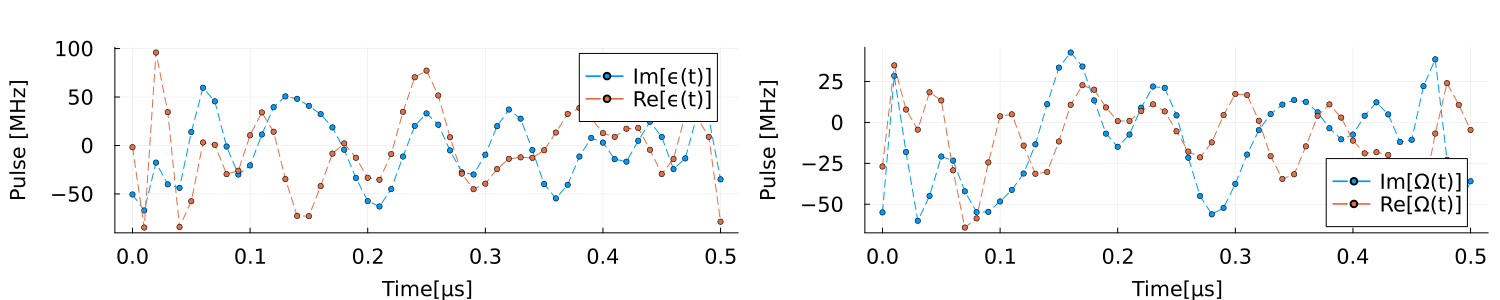

In [23]:
imaginary_part = plot([l for l in 0:T*d /50:T*d], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, layout=2, subplot=1, size=(1500,300), margin=10mm,xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /50:T*d], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*d /50:T*d], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, subplot=2, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /50:T*d], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, subplot=2)
#savefig("../../plots/pulse_optimisation/x7photons_100timesteps_100ns_1dote-2Infidelity.pdf")

In [ ]:
g(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T / (50), x, RZ, ω_c, ω_q, 1, 1)

In [ ]:
res_reseding = Optim.optimize(g,optimised_coeffs[1:18] , LBFGS(), Optim.Options(show_trace=true, show_every=50))

In [ ]:
optimised_coeffs_2 = Optim.minimizer(res_reseding)

In [ ]:
coeffs_cavity = optimised_coeffs_2[1:9]
coeffs_qubit = optimised_coeffs_2[10:end]

In [ ]:
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T, t)

amps_c = [amplitude_c(l) for l in 0:T/50:T]
amps_q = [amplitude_q(l)  for l in 0:T/50:T]

In [ ]:
imaginary_part = plot([l for l in 0:T /50:T], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T /50:T], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T /50:T], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T /50:T], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)


In [ ]:
g(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T*2, T*2 / (200), x, RZ, ω_c, ω_q, 1, 1)

In [ ]:
res_reseding_2 = Optim.optimize(g,optimised_coeffs_2 , LBFGS(), Optim.Options(show_trace=true, show_every=10))

In [ ]:
optimised_coeffs_3 = Optim.minimizer(res_reseding_2)
res_reseding_2_bis = Optim.optimize(g,optimised_coeffs_3 , LBFGS(), Optim.Options(show_trace=true, show_every=10))

In [ ]:
coeffs_cavity = optimised_coeffs_3[1:7]
coeffs_qubit = optimised_coeffs_3[8:end]
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*2, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*2, t)

amps_c = [amplitude_c(l) for l in 0:T*2/(200):T*2]
amps_q = [amplitude_q(l)  for l in 0:T*2/(200):T*2]

In [ ]:
imaginary_part = plot([l for l in 0:T*2 / (200):T*2], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*2 / (200):T*2], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)

In [ ]:
optimised_coeffs_3_bis = Optim.minimizer(res_reseding_2_bis)
coeffs_cavity = optimised_coeffs_3_bis[1:7]
coeffs_qubit = optimised_coeffs_3_bis[8:end]
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*2, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*2, t)

amps_c = [amplitude_c(l) for l in 0:T*2/(200):T*2]
amps_q = [amplitude_q(l)  for l in 0:T*2/(200):T*2]

imaginary_part = plot([l for l in 0:T*2 / (200):T*2], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*2 / (200):T*2], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)

In [ ]:
optimised_coeffs_3_bis = Optim.minimizer(res_reseding_2_bis)